## Library

In [1]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch.optim.lr_scheduler import LambdaLR

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import sympy

## Developed code

In [2]:
from SymbolicRNN import SymbolicRNN
from stringAgraph import stringAgraph
from evaluateAgraph import evaluateAgraph
from localOptimizer import localOptimizer
from Agraph import Agraph, binary_node
from defineAgraph import defineAgraph

In [3]:
if torch.cuda.is_available():
    print("Good to go!")
    device = "cuda"
else:
    device = 'cpu'

Good to go!


## Select operators 

In [4]:
selected_operator = ['+','-','*']

In [5]:
idx_to_op = ['<NULL>','c','x','/']
idx_to_op += selected_operator
op_to_idx = {w: i for i, w in enumerate(idx_to_op)}
D = len(idx_to_op)
print("The size of dictionary is:{}".format(D))
print("idx_to_op:",idx_to_op)
print("op_to_idx:",op_to_idx)

The size of dictionary is:7
idx_to_op: ['<NULL>', 'c', 'x', '/', '+', '-', '*']
op_to_idx: {'<NULL>': 0, 'c': 1, 'x': 2, '/': 3, '+': 4, '-': 5, '*': 6}


## Training algorithm

In [6]:
def training(X,y,idx_to_op,op_to_idx,D,E,H,maxiter,threshold,epoch,method):
    
    model = SymbolicRNN(idx_to_op,op_to_idx,
                     X,y,
                     method,maxiter,threshold,
                     D,E,H)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    best_model = None
    best_reward = -np.inf
    reward_array,mean_reward_array = [],[]
    loss_array = []
    
    for j in range(epoch):
        
        optimizer.zero_grad()
        agraph,loss,reward,meanReward = model(deterministic=False)
        loss.backward()
        optimizer.step()
        
        if reward>best_reward:
            best_model = model
            best_reward = reward
            best_meanR = meanReward
            best_agraph = agraph
            best_loss = loss
            
        
        
        reward_array.append(best_reward.item())
        mean_reward_array.append(best_meanR.item())
        loss_array.append(loss.item())
        
        if j%50==0:
            print('epoch {}:{}'.format(j,reward))
            
            
    print('epoch {}:{}'.format(j,best_reward))
    return best_agraph,reward_array,mean_reward_array,loss_array

## Test-1

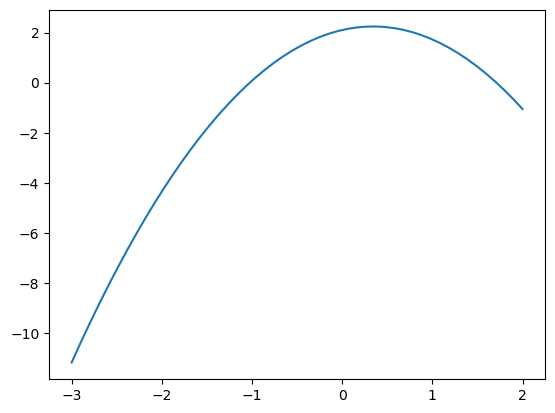

In [7]:
n = 50
X = np.linspace(-3,2,n)
y = - 1.2*X**2 + 0.823*X + 2.1
plt.plot(X,y)

In [8]:
D,E,H = len(idx_to_op),10,6
maxiter = 21
threshold = 0.2
epoch = 500
method = 'rmm'

best_agraph,reward_array,mean_reward_array,loss_array = training(X,y,idx_to_op,op_to_idx,D,E,H,maxiter,threshold,epoch,method)

epoch 0:0.5001065416012495


C:\Users\hongs\Downloads\DSA\evaluateAgraph.py:38: RuntimeWarning: divide by zero encountered in true_divide
  return left_sum / right_sum


epoch 50:0.7224654028427501
epoch 100:0.6182385431395706
epoch 150:0.5001065415980464
epoch 200:0.9999999735587337
epoch 250:0.7686823076376327
epoch 300:0.6190339182623334
epoch 350:0.4911385038784339
epoch 400:0.5039569990561574
epoch 450:0.6183466775291997


C:\Users\hongs\Downloads\DSA\evaluateAgraph.py:38: RuntimeWarning: invalid value encountered in true_divide
  return left_sum / right_sum


epoch 499:0.9999999967249313


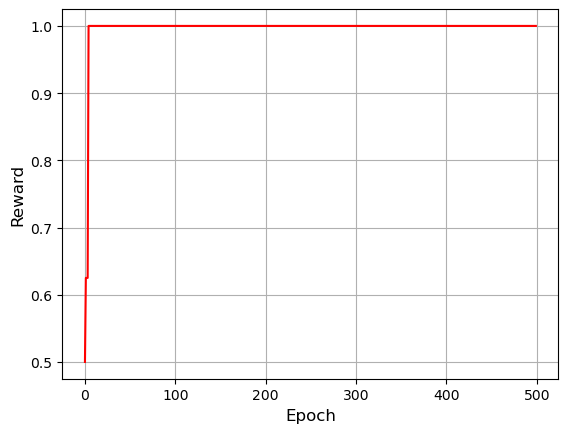

In [9]:
plt.plot(np.arange(0,len(reward_array)),reward_array,color='red')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Reward',fontsize=12)
plt.grid()

In [10]:
exp = stringAgraph(best_agraph.root,idx_to_op)
print('Obtained equation is: ',sympy.expand(exp))
print('Target expression is: - 1.2*X**2 + 0.823*X + 2.1')

Obtained equation is:  -1.2000000051728507*x**2 + 0.82299999110136081*x + 2.1000000128126399
Target expression is: - 1.2*X**2 + 0.823*X + 2.1


In [11]:
constants = localOptimizer(best_agraph,best_agraph.root,X,y,idx_to_op)

In [12]:
y_hat = evaluateAgraph(best_agraph.root,idx_to_op,X,constants)

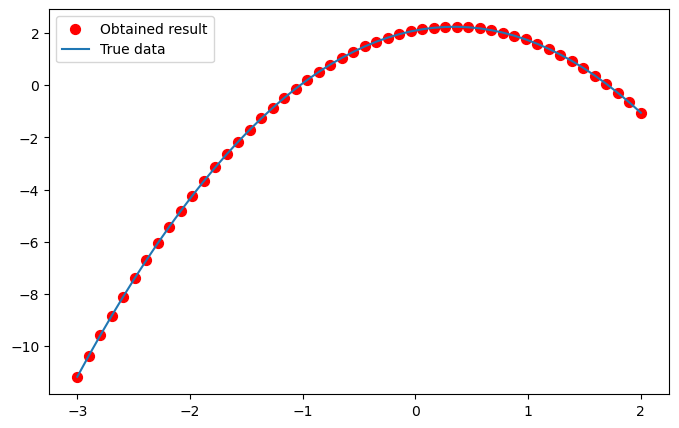

In [13]:
plt.figure(figsize = (8,5))
plt.scatter(X,y_hat,color='red',s=50,label='Obtained result')
plt.plot(X,y,label='True data')
plt.legend()

## Test - 2

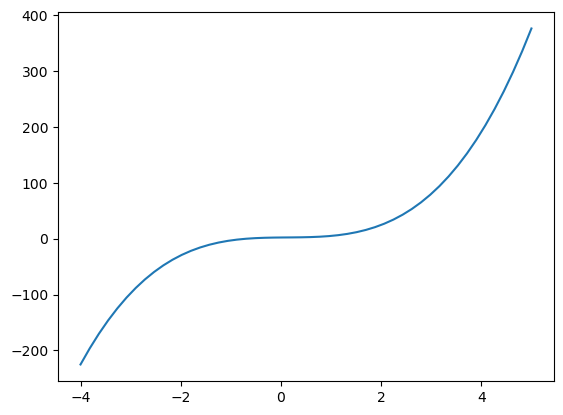

In [14]:
n = 50
X = np.linspace(-4,5,n)
y = 3.2*X**3 - 1.2*X**2 + 0.823*X + 2.1
plt.plot(X,y)

In [15]:
D,E,H = len(idx_to_op),10,4
maxiter = 21
threshold = 0.3
epoch = 250
method = 'LSTM'

best_agraph,reward_array,mean_reward_array,loss_array = training(X,y,idx_to_op,op_to_idx,D,E,H,maxiter,threshold,epoch,method)

epoch 0:0.5024174331451944
epoch 50:0.7048251133549303
epoch 100:0.7032433401310676
epoch 150:0.5000894348546899
epoch 200:0.4933818982205091
epoch 249:0.9999997874745149


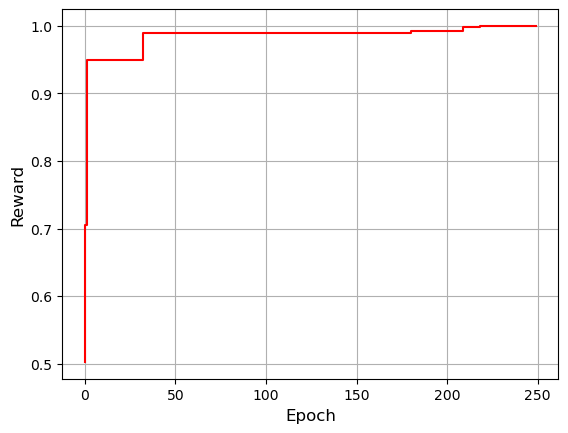

In [16]:
plt.step(np.arange(0,len(reward_array)),reward_array,color='red')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Reward',fontsize=12)
plt.grid()

In [17]:
exp = stringAgraph(best_agraph.root,idx_to_op)
print('Obtained equation is: ',sympy.expand(exp))
print('Target expression is: 3.2*X**3 - 1.2*X**2 + 0.823*X + 2.1')

Obtained equation is:  3.2000013312808227*x**3 - 1.2000038882051485*x**2 + 0.82298290100049064*x + 2.100032889029327
Target expression is: 3.2*X**3 - 1.2*X**2 + 0.823*X + 2.1


In [18]:
constants = localOptimizer(best_agraph,best_agraph.root,X,y,idx_to_op)

In [19]:
y_hat = evaluateAgraph(best_agraph.root,idx_to_op,X,constants)

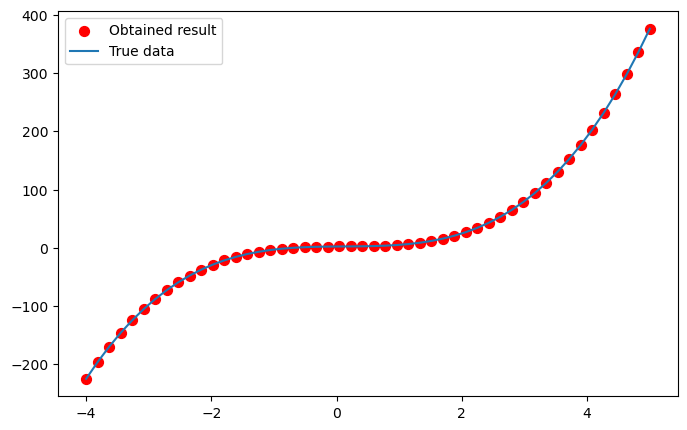

In [20]:
plt.figure(figsize = (8,5))
plt.scatter(X,y_hat,color='red',s=50,label='Obtained result')
plt.plot(X,y,label='True data')
plt.legend()

## Test - 3

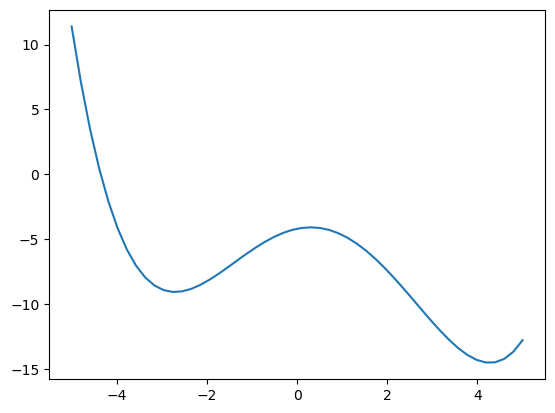

In [21]:
n = 50
X = np.linspace(-5,5,n)
y = 0.05*X**4 - 0.125*X**3 - 1.11*X**2 + 0.7053*X - 4.2
plt.plot(X,y)

In [22]:
D,E,H = len(idx_to_op),10,4
maxiter = 41
threshold = 0.3
epoch = 500
method = 'LSTM'

best_agraph,reward_array,mean_reward_array,loss_array = training(X,y,idx_to_op,op_to_idx,D,E,H,maxiter,threshold,epoch,method)

epoch 0:0.40828477605605235
epoch 50:0.6710416588100199
epoch 100:0.5824487919099438
epoch 150:0.5899496803267343
epoch 200:0.6665070502335753
epoch 250:0.6554152155081457
epoch 300:0.5461272006601955
epoch 350:0.0
epoch 400:0.045179138372851084
epoch 450:0.6664934017345002
epoch 499:0.9999999386542868


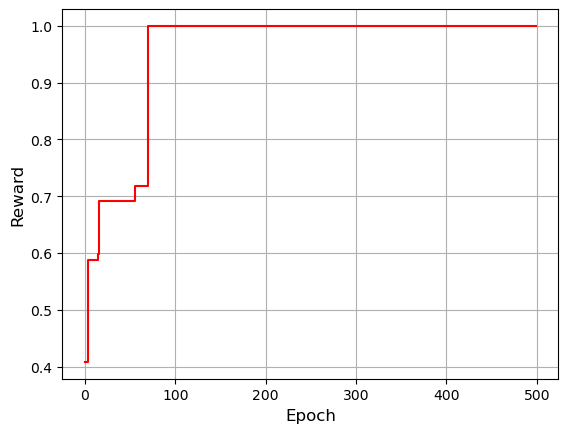

In [23]:
plt.step(np.arange(0,len(reward_array)),reward_array,color='red')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Reward',fontsize=12)
plt.grid()

In [24]:
exp = stringAgraph(best_agraph.root,idx_to_op)
print('Obtained equation is: ',sympy.expand(exp))
print('Target expression is: 0.05*X**4 - 0.125*X**3 - 1.11*X**2 + 0.7053*X - 4.2')

Obtained equation is:  0.05000000452956211*x**4 - 0.1250000076783682*x**3 - 1.11000011598155*x**2 + 0.705300090322394*x - 4.199999614828039
Target expression is: 0.05*X**4 - 0.125*X**3 - 1.11*X**2 + 0.7053*X - 4.2


In [25]:
y_hat = evaluateAgraph(best_agraph.root,idx_to_op,X,constants)

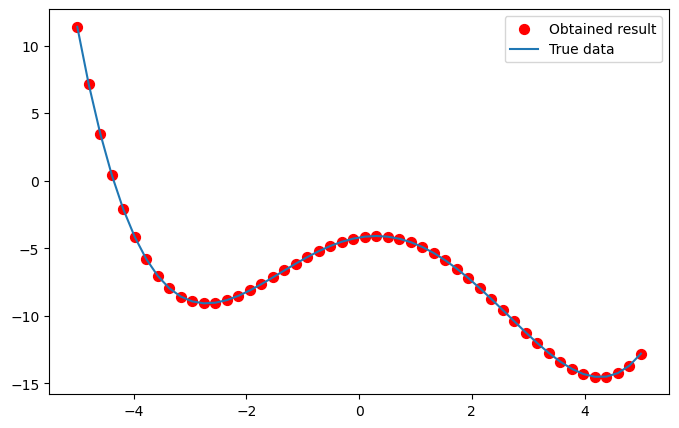

In [26]:
plt.figure(figsize = (8,5))
plt.scatter(X,y_hat,color='red',s=50,label='Obtained result')
plt.plot(X,y,label='True data')
plt.legend()

## Test - 4

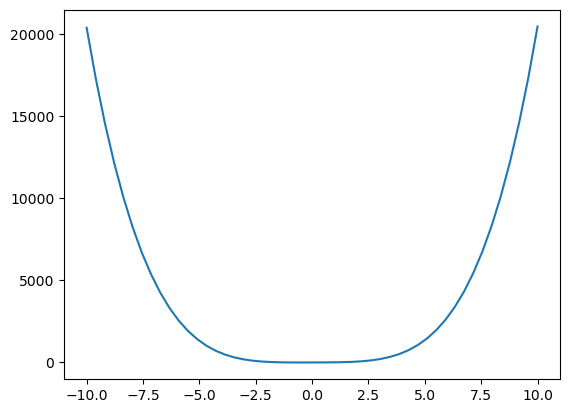

In [27]:
n = 50
X = np.linspace(-10,10,n)
y =  2.01*X**4 + 3.2*X**2 + 4*X 
plt.plot(X,y)

In [28]:
D,E,H = len(idx_to_op),10,4
maxiter = 31
threshold = 0.3
epoch = 500
method = 'LSTM'

best_agraph,reward_array,mean_reward_array,loss_array = training(X,y,idx_to_op,op_to_idx,D,E,H,maxiter,threshold,epoch,method)

epoch 0:0.9960151274377304
epoch 50:0.4508308499742747
epoch 100:0.5000020008309468
epoch 150:0.4435009410689833
epoch 200:0.992704327456313
epoch 250:0.499927432468391
epoch 300:0.4997190996411235
epoch 350:0.7496658231006116
epoch 400:0.7404547581866913
epoch 450:0.44350106952709445
epoch 499:0.9999996070140981


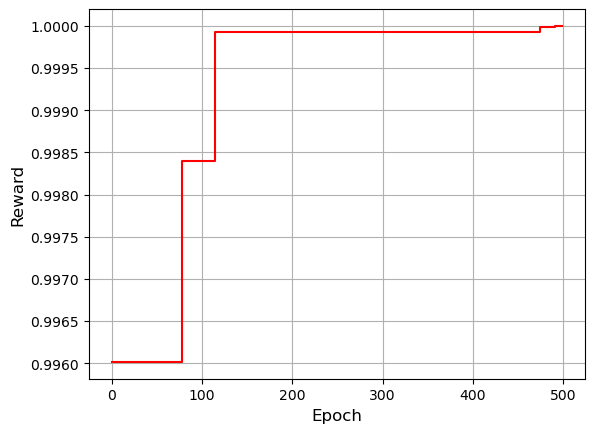

In [29]:
plt.step(np.arange(0,len(reward_array)),reward_array,color='red')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Reward',fontsize=12)
plt.grid()

In [30]:
exp = stringAgraph(best_agraph.root,idx_to_op)
print('Obtained equation is: ',sympy.expand(exp))
print('Target expression is: 2.01*X**4 + 3.2*X**2 + 4*X')

Obtained equation is:  2.0099988252018811*x**4 - 7.579842858978396e-6*x**3 + 3.200120535401613*x**2 + 4.0005006859821076*x
Target expression is: 2.01*X**4 + 3.2*X**2 + 4*X


In [31]:
constants = localOptimizer(best_agraph,best_agraph.root,X,y,idx_to_op)

In [32]:
y_hat = evaluateAgraph(best_agraph.root,idx_to_op,X,constants)

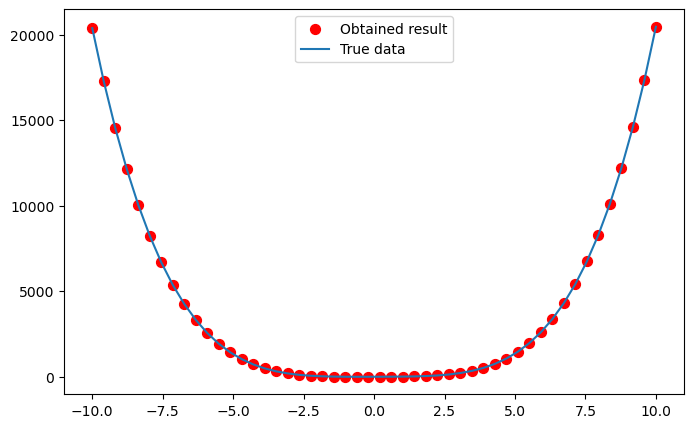

In [33]:
plt.figure(figsize = (8,5))
plt.scatter(X,y_hat,color='red',s=50,label='Obtained result')
plt.plot(X,y,label='True data')
plt.legend()